In [2]:
import pandas as pd
import pymongo
import os

### Mount Google Drive for saving the model

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load the data from BigQuery

In [4]:
from google.cloud import bigquery

In [5]:
service_account_info = {
  "type": os.environ.get("type"),
  "project_id": os.environ.get("project_id"),
  "private_key_id": os.environ.get("private_key_id"),
  "private_key": os.environ.get("private_key"),
  "client_email": os.environ.get("client_email"),
  "client_id": os.environ.get("client_id"),
  "auth_uri": os.environ.get("auth_uri"),
  "token_uri": os.environ.get("token_uri"),
  "auth_provider_x509_cert_url": os.environ.get("auth_provider_x509_cert_url"),
  "client_x509_cert_url": os.environ.get("client_x509_cert_url"),
  "universe_domain": os.environ.get("universe_domain")
}

In [6]:
client = bigquery.Client.from_service_account_info(service_account_info)

In [7]:
sql_query = """
        SELECT *
        FROM
            `disco-math-385807.traffooze.traffic_flow_data`
    """

In [8]:
query_job = client.query(sql_query)

In [9]:
df = query_job.to_dataframe()

In [10]:
df.head()

road_id           timestamp      speed  speedUncapped   freeFlow  \
0     1095 2023-08-08 06:25:00   8.888889       8.888889   8.611112   
1     1096 2023-08-08 06:25:00   9.847686       9.847686   9.851027   
2     1101 2023-08-08 06:25:00  11.666667      11.666667  11.944445   
3     1103 2023-08-08 06:25:00   9.722222       9.722222  10.000000   
4     1106 2023-08-08 06:25:00   7.777778       7.777778   9.722222   

   jamFactor  temperature  humidity  pressure  visibility  wind_speed  \
0   0.000000        27.93      85.0    1010.0     10000.0        3.09   
1   0.221693        27.93      85.0    1010.0     10000.0        3.09   
2   0.100000        27.93      86.0    1011.0     10000.0        2.57   
3   0.100000        27.98      85.0    1010.0     10000.0        3.09   
4   1.400000        27.98      85.0    1010.0     10000.0        3.09   

   wind_degree  wind_gust  clouds  rain_3h  
0        130.0        0.0    75.0      0.0  
1        130.0        0.0    75.0      0.0  
2         90.0        0.0    75.0      0.0  
3        130.0        0.0    40.0      0.0  
4        130.0        0.0    40.0      0.0

### Merge Data with Roads Metadata such as Length, Starting Latitude and Starting Longitude, stored in mongoDB

In [11]:
mongo_url = os.environ.get("mongo_uri")
client = pymongo.MongoClient(mongo_url)
db = client['TraffoozeDBS']
collection = db['roads_metadata']

projection = {"_id": 0}

cursor = collection.find(projection=projection)

data_list = list(cursor)
metadata_df = pd.DataFrame(data_list)

client.close()

In [12]:
metadata_columns = ['road_id', 'length', 'start_lat', 'start_lng']
selected_metadata = metadata_df[metadata_columns]

In [13]:
df = df.merge(selected_metadata, on='road_id', how='left')

In [14]:
df.dropna(inplace=True)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1497097 entries, 0 to 1498069
Data columns (total 18 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   road_id        1497097 non-null  Int64         
 1   timestamp      1497097 non-null  datetime64[ns]
 2   speed          1497097 non-null  float64       
 3   speedUncapped  1497097 non-null  float64       
 4   freeFlow       1497097 non-null  float64       
 5   jamFactor      1497097 non-null  float64       
 6   temperature    1497097 non-null  float64       
 7   humidity       1497097 non-null  float64       
 8   pressure       1497097 non-null  float64       
 9   visibility     1497097 non-null  float64       
 10  wind_speed     1497097 non-null  float64       
 11  wind_degree    1497097 non-null  float64       
 12  wind_gust      1497097 non-null  float64       
 13  clouds         1497097 non-null  float64       
 14  rain_3h        1497097 non-null  f

In [16]:
length = df["length"]
start_lat = df["start_lat"]
start_lng = df["start_lng"]

df.drop(["length", "start_lat", "start_lng"], axis=1, inplace=True)
df.insert(1, "length", length)
df.insert(2, "start_lat", start_lat)
df.insert(3, "start_lng", start_lng)

In [17]:
df.drop(['speedUncapped', 'freeFlow'], axis=1, inplace=True)

### Extract Date and Time Attributes from Timestamp

In [18]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Extract year, month, date, hour, and minute components into separate columns
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['day'] = df['timestamp'].dt.day
df['hour'] = df['timestamp'].dt.hour
df['minute'] = df['timestamp'].dt.minute

df['dayofweek'] = df['timestamp'].dt.dayofweek

df['weekofyear'] = df['timestamp'].dt.isocalendar().week

df['IsWeekday'] = df['dayofweek'].apply(lambda x: 1 if x < 5 else 0)
df['IsWeekend'] = df['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)

df = df.drop("timestamp", axis=1)

In [19]:
df

road_id  length  start_lat  start_lng      speed  jamFactor  \
0           1095  2245.0    1.30120  103.85779   8.888889   0.000000   
1           1096  3827.0    1.29524  103.87262   9.847686   0.221693   
2           1101  1580.0    1.29935  103.77474  11.666667   0.100000   
3           1103  1421.0    1.39817  103.85761   9.722222   0.100000   
4           1106  1027.0    1.40057  103.86744   7.777778   1.400000   
...          ...     ...        ...        ...        ...        ...   
1498065     1077  1690.0    1.29436  103.85879  13.526908   0.000000   
1498066     1079  1015.0    1.28461  103.85321   9.536329   0.333461   
1498067     1081   789.0    1.31357  103.85434   7.777778   0.200000   
1498068     1083   948.0    1.29609  103.86235  15.707866   0.098517   
1498069     1090   681.0    1.39131  103.90140   8.989945   0.452454   

         temperature  humidity  pressure  visibility  ...  rain_3h  year  \
0              27.93      85.0    1010.0     10000.0  ...      0.0  2023   
1              27.93      85.0    1010.0     10000.0  ...      0.0  2023   
2              27.93      86.0    1011.0     10000.0  ...      0.0  2023   
3              27.98      85.0    1010.0     10000.0  ...      0.0  2023   
4              27.98      85.0    1010.0     10000.0  ...      0.0  2023   
...              ...       ...       ...         ...  ...      ...   ...   
1498065        27.93      85.0    1010.0     10000.0  ...      0.0  2023   
1498066        27.93      85.0    1010.0     10000.0  ...      0.0  2023   
1498067        27.93      85.0    1010.0     10000.0  ...      0.0  2023   
1498068        27.93      85.0    1010.0     10000.0  ...      0.0  2023   
1498069        27.95      84.0    1010.0     10000.0  ...      0.0  2023   

         month  day  hour  minute  dayofweek  weekofyear  IsWeekday  IsWeekend  
0            8    8     6      25          1          32          1          0  
1            8    8     6      25          1          32          1          0  
2            8    8     6      25          1          32          1          0  
3            8    8     6      25          1          32          1          0  
4            8    8     6      25          1          32          1          0  
...        ...  ...   ...     ...        ...         ...        ...        ...  
1498065      8    8     6      25          1          32          1          0  
1498066      8    8     6      25          1          32          1          0  
1498067      8    8     6      25          1          32          1          0  
1498068      8    8     6      25          1          32          1          0  
1498069      8    8     6      25          1          32          1          0  

[1497097 rows x 24 columns]

In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

### Split data into training and testing set

In [21]:
X = df.drop(['speed', 'jamFactor'], axis=1)
y = df[['speed', 'jamFactor']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

###Train Model

In [22]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the Random Forest model
rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf.predict(X_test)

###Evaluate Model Performance on Testing Set

In [23]:
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

r2 = r2_score(y_test, y_pred)
print('R-squared:', r2)

Mean Squared Error: 0.4912132820404742
R-squared: 0.8771954186565175


# Visualizations

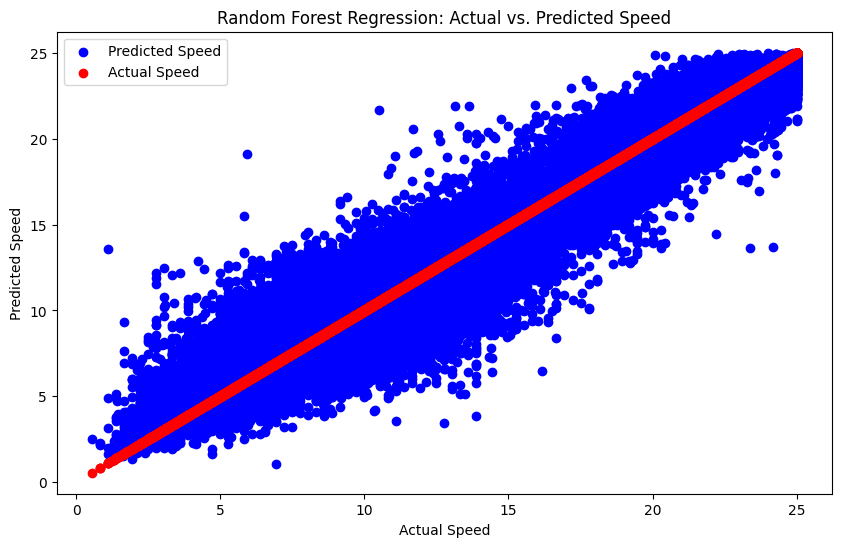

In [27]:
import matplotlib.pyplot as plt

# Plotting the predictions against the actual results
plt.figure(figsize=(10, 6))
plt.scatter(y_test['speed'], y_pred[:, 0], color='blue', label='Predicted Speed')
plt.scatter(y_test['speed'], y_test['speed'], color='red', label='Actual Speed')
plt.xlabel('Actual Speed')
plt.ylabel('Predicted Speed')
plt.title('Random Forest Regression: Actual vs. Predicted Speed')
plt.legend()
plt.show()

**Plotting only the first 15000 rows**

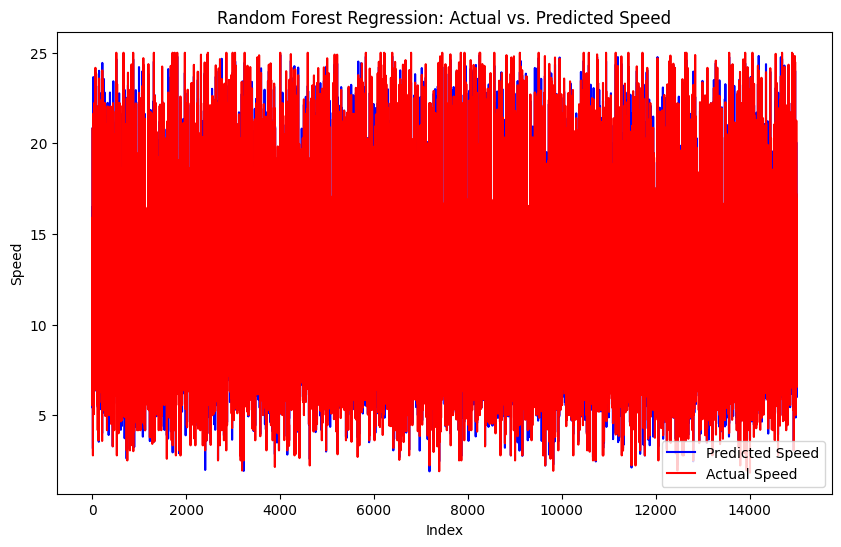

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Create an array of indices for the x-axis
x_indices = np.arange(15000)

# Plotting the predictions against the actual results
plt.figure(figsize=(10, 6))
plt.plot(x_indices, y_pred[:15000, 0], color='blue', label='Predicted Speed')
plt.plot(x_indices, y_test['speed'].iloc[:15000], color='red', label='Actual Speed')
plt.xlabel('Index')
plt.ylabel('Speed')
plt.title('Random Forest Regression: Actual vs. Predicted Speed')
plt.legend()
plt.show()


###Saving/Pickling the model as a file,
###So that it can be used for generating predictions

In [26]:
import joblib

In [24]:
model_save_path = '/content/drive/MyDrive/Colab Notebooks/rf_traffic_flow.sav'
joblib.dump(rf, model_save_path)

['/content/drive/MyDrive/Colab Notebooks/rf_traffic_flow.sav']


### Fine Tuning the model

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees
    'max_depth': [None, 5, 10],  # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}

In [ ]:
fine_rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(fine_rf, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)

In [ ]:
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

In [ ]:
best_params

In [ ]:
best_model

In [ ]:
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error on test set:", mse)

### We find that fine tuning the model using GridSearchCV did not actually improve the performance of the model on the test set